# Algorithm for dog breed identification

Here we use the functions that are written in this project to create a CNN from scratch. We then use the CNN to predict breeds of user-supplied dog or human images, and output some nice graphs.


Note:
Before running this notebook, make sure all the data is situated in `data/raw` in the project. See the README for more details.


In [1]:
from glob import glob
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets

from PIL import Image
import matplotlib.pyplot as plt

from src.data import data_loader
from src.models import detect_faces, detect_dogs, train_model, cnn_from_scratch, test_model, predict_model
from src.utils import un_normalize_image

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
TRAIN_DATA_PATH = "../data/raw/dogImages/train"
VALIDATION_DATA_PATH = "../data/raw/dogImages/valid"
TEST_DATA_PATH = "../data/raw/dogImages/test"

In [4]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [5]:
random.seed(12)

# load filenames for human and dog images
human_files = np.array(glob("../data/raw/lfw/*/*"))
dog_files = np.array(glob("../data/raw/dogImages/*/*/*"))
random.shuffle(human_files)
random.shuffle(dog_files)

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [6]:
breeds = [x.split('/')[3].split("\\")[3][:-10] for x in dog_files]
breeds = np.unique(breeds)
print(f"There are {len(breeds)} breeds in total\n")
print(f"example breeds: \n{breeds[:5]}")

There are 133 breeds in total

example breeds: 
['Affenpinscher' 'Afghan_hound' 'Airedale_terrier' 'Akita'
 'Alaskan_malamute']



## Step 1: Detect Humans and dogs



In [7]:
# pick some human and dog files to test our face detector on
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

In [8]:
# Test the performance of the face_detector algorithm 
human_count = 0
dog_count = 0

for ii, human_path in enumerate(human_files_short):
    human_count += detect_faces.face_detector(human_path)
    dog_count += detect_faces.face_detector(dog_files_short[ii])
    
print(f'Faces were detected in {human_count}% of our human images, and {dog_count}% of our dog images')

Faces were detected in 98% of our human images, and 11% of our dog images


In [9]:
dog_detector_model = detect_dogs.get_dog_detector_model()

# Testing the dog detector. This may take a while to run because of loading the vgg16 model. 
human_count = 0
dog_count = 0

for ii, human_path in enumerate(human_files_short):
    human_count += detect_dogs.dog_detector(human_path, dog_detector_model)
    dog_count += detect_dogs.dog_detector(dog_files_short[ii], dog_detector_model)
    
print(f'Dogs were detected in {human_count}% of our human images, and {dog_count}% of our dog images')

Dogs were detected in 0% of our human images, and 96% of our dog images


## Step 2: Create a CNN to Classify Dog Breeds (from Scratch)

### Data transformation and loaders

In [10]:
# data transformations
data_transform_crop = transforms.Compose([
                            transforms.Resize(224),
                            transforms.RandomResizedCrop(224),
                            transforms.RandomAffine(degrees=10, 
                                                    translate=(0.15, 0.15), 
                                                    scale=(0.8, 1.2)),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                 std=[0.5, 0.5, 0.5])])

data_transform_resize  = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.RandomAffine(degrees=10, 
                                                    translate=(0.15, 0.15), 
                                                    scale=(0.8, 1.2)),
                            transforms.ColorJitter(brightness = 0.3,
                                                  contrast = 0.5,
                                                  saturation=0.5),
                            transforms.RandomGrayscale(p=0.1),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                 std=[0.5, 0.5, 0.5])])

data_transform_bare  = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                 std=[0.5, 0.5, 0.5])])

train_data_crop = datasets.ImageFolder(TRAIN_DATA_PATH, transform=data_transform_crop)
train_data_resize = datasets.ImageFolder(TRAIN_DATA_PATH, transform=data_transform_resize)
valid_data = datasets.ImageFolder(VALIDATION_DATA_PATH, transform=data_transform_bare)
test_data = datasets.ImageFolder(TEST_DATA_PATH, transform=data_transform_bare)

# to find out what cropped images look like
train_loader_crop = torch.utils.data.DataLoader(train_data_crop, batch_size=25, shuffle=True, num_workers=0)
train_loader_resize = torch.utils.data.DataLoader(train_data_resize, batch_size=15, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=15, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=15, shuffle=True, num_workers=0)

# the loader I'll eventually use, don't use the crop one.
loaders = {'train' : train_loader_resize, 'valid' : valid_loader, 'test': test_loader}

# Look at some images
### Look at original images
From these images it seems that a lot of them are relatively long with the dog sitting up and its head at the top of the image. When we crop the images, there's a chance of cutting off the dog's face, which is what I originally saw when looking at my cropped and rotated images. It's probably better not to lose the dog's face..

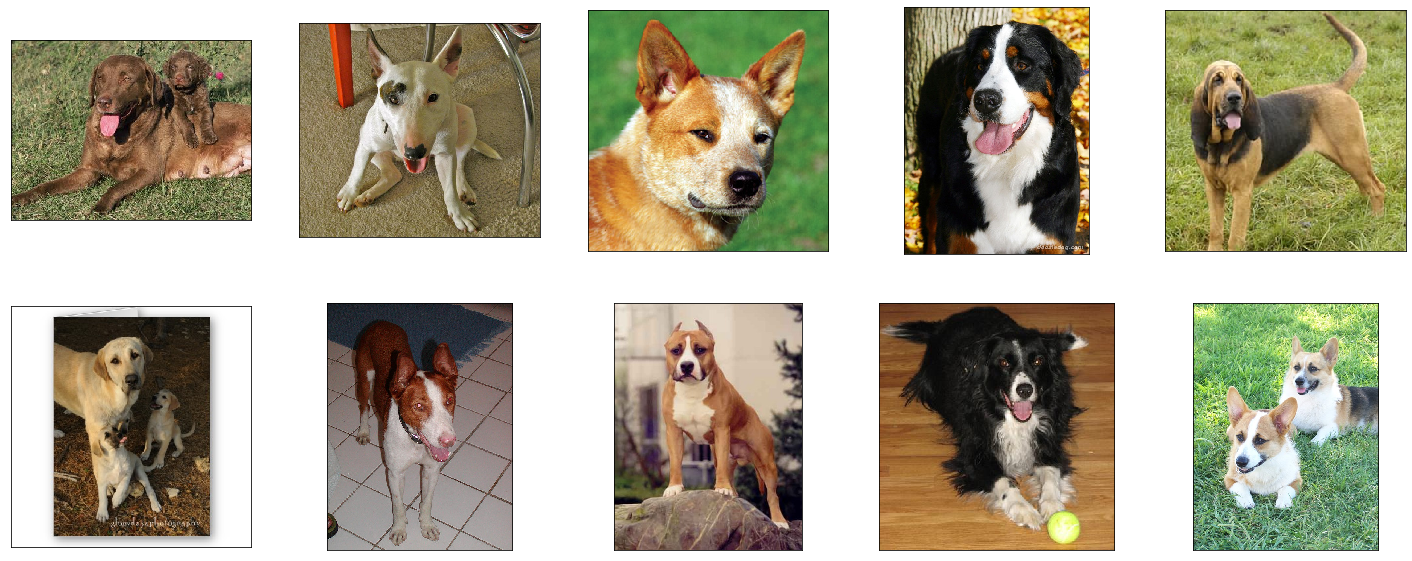

In [11]:
indices = np.random.randint(0, len(dog_files), 10)
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(10):
    image = Image.open(dog_files[idx])
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(image)

### Look at transformed images
see if the transformations we applied (rotation, translation, etc..) are not too disturbing, it shouldn't be we cannot recognize the dogs ourselves anymore

In [12]:
# helper function to un-normalize and display an image
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
un_norm = un_normalize_image.UnNormalize()

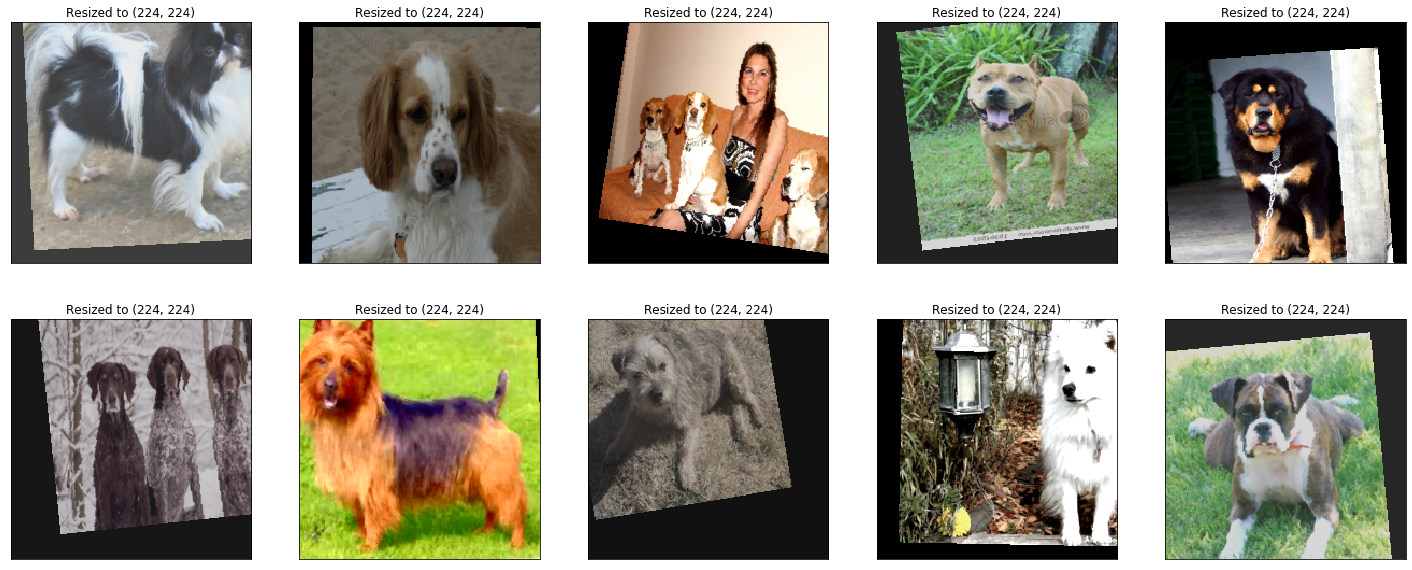

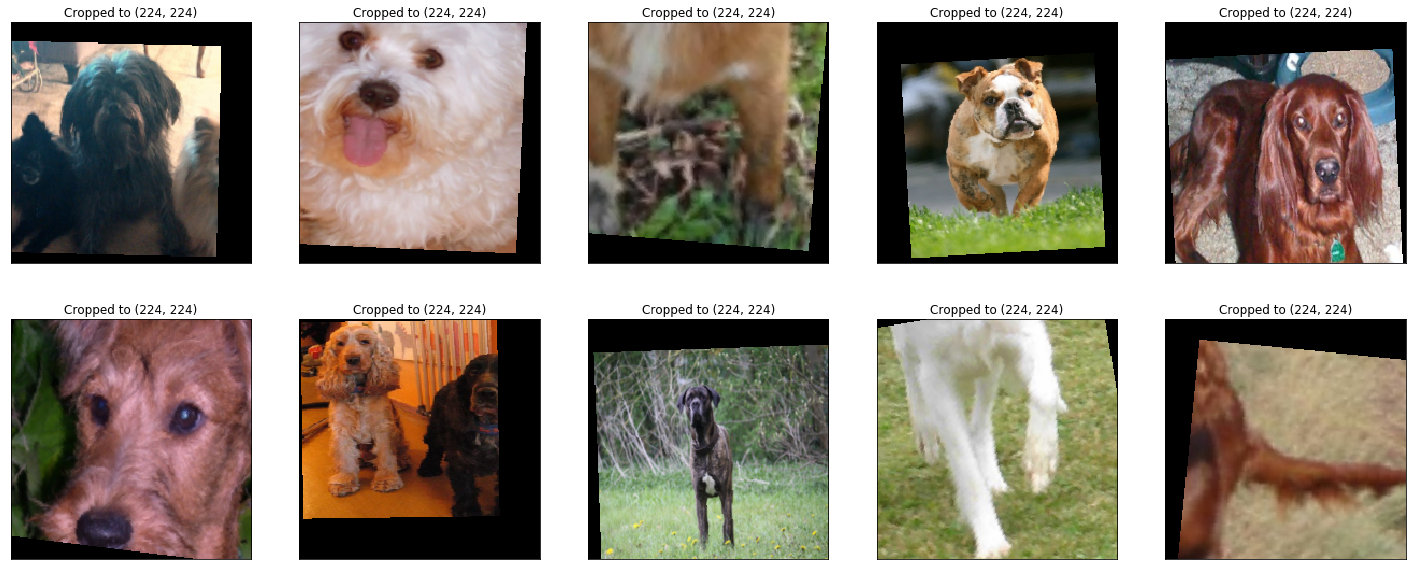

In [13]:
# obtain one batch of training images
dataiter_crop = iter(train_loader_crop)
dataiter = iter(train_loader_resize)

images_crop, _ = dataiter_crop.next()
images_resize, _ = dataiter.next()


#### RESIZED IMAGES
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(10):
    
    # resized images
    image = un_norm(images_resize[idx])
    image = image.numpy()    

    # show images
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(image)
    ax.set_title('Resized to (224, 224)')


#### CROPPED IMAGES
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(10):
    
    # cropped images
    image = un_norm(images_crop[idx])
    image = image.numpy()

    # show images
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(image)
    ax.set_title('Cropped to (224, 224)')


**Motivate chosen procedure for preprocessing data**:

I had originally cropped the images to 224x224 pixel images, which is what is required for vgg16. Then I noticed that a lot of my dogs were missing their faces due to the cropping (e.g. of a lot of the pictures were quite tall compared to wide, then the top part of the picture (i.e. the head) can easily be cut off). I then decided to resize the images to 224x224 rather than cropping. 

I included some rotations, translations and colour jitter. The colour jitter might be useful because, though a lot of information is in the colours of the dogs, some breeds occur in different colours (like labradors, as also noted above) and it might be good to not depend on colour too much. Also, us humans can still recognize a german shepherd even if its colours are a big weird, so the neural network should be able to do this too.

I included horizontal flips, but no vertical flips as the vertical ones seem a bit unrealistic.

# Define and train the model


### model architecture
The architecture of the CNN is defined in src/models/cnn_from_scratch. I tried out a few different architectures. Initially I had constructed my model such that the first few layers were the same as those of the vgg16 model, meaning that my first convolution layer had an output size of 64. This didn't work very well and eventually I increased the number of filters more slowly. 

In the end five convolutional layers worked better than 4, and also I reduced the output size of my first fully connected layer (originally I had set it at 4000 but that did not work well). 

I also changed changed the batch-size a bunch of times, from 50 to 32 to 10 to 25. 

In [14]:
model = cnn_from_scratch.Net()
if use_cuda:
    model.cuda()

### Specify Loss Function and Optimizer


In [15]:
# select loss function
criterion = nn.CrossEntropyLoss()

# select optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)

### Train and Validate the Model

Here we train and test our model. I had already trained the model on a gpu earlier, and saved the trained model as `models/model_scratch_90.pt` path from root directory of project). So I'm not training it here in the notebook at the moment. I load in the trained model two cells below here. 

Of course a new model can be trained in the cell below here, though if there is no gpu available it may take a while.


In [ ]:
# train the model
n_epochs = 10
model = train_model.train(n_epochs=n_epochs, 
                           loaders=loaders, 
                           model=model, 
                           optimizer=optimizer, 
                           criterion=criterion, 
                           use_cuda=use_cuda, 
                           save_path=f"../models/model_scratch_{n_epochs}.pt")
torch.cuda.empty_cache()

Starting epoch 1
	Training..


In [16]:
# load the model that got the best validation accuracy.
# This cell will only run successfully if the model 'model_scratch_90' exists of course
n_epochs = 90
model.load_state_dict(torch.load(f"../models/model_scratch_{n_epochs}.pt", map_location=lambda storage, loc: storage,))

<All keys matched successfully>

### Test the Model

Here we test out the model on some dog images, we print the test loss and accuracy.

I ran the model for about 90 epochs, and I got 47% accuracy, which seems very reasonable (given that random chance should only give us 0.75% accuracy (given there are 133 classes)). 

In [17]:
# call test function    
test_model.test(model, criterion, use_cuda, test_data_path=TEST_DATA_PATH)

Test Loss: 1.947856
Test Accuracy: 47% (395/836)


### Predict Dog Breed with the Model

Here we use the function `create_prediction_fig` in `src/models/predict_model`, which 
* uses the supplied model to predict the most likely class of the supplied image
* plots a figure with
    * the supplied image itself
    * a bar plot of the top five classes with highest probability
    * an image of the top dog with highest probability

In [18]:
test_dogs = np.array(glob("../data/raw/dogImages/test/*/*"))
random.shuffle(test_dogs)
test_dogs = test_dogs[:10]

Predicting for dog Chinese_shar-pei


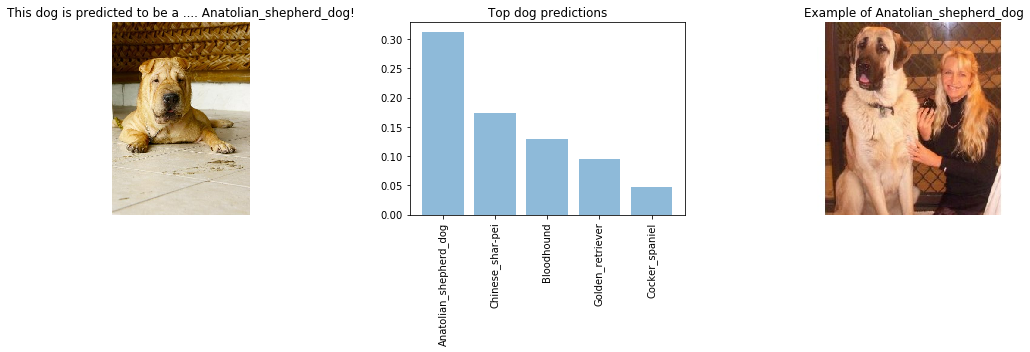

Predicting for dog American_eskimo_dog


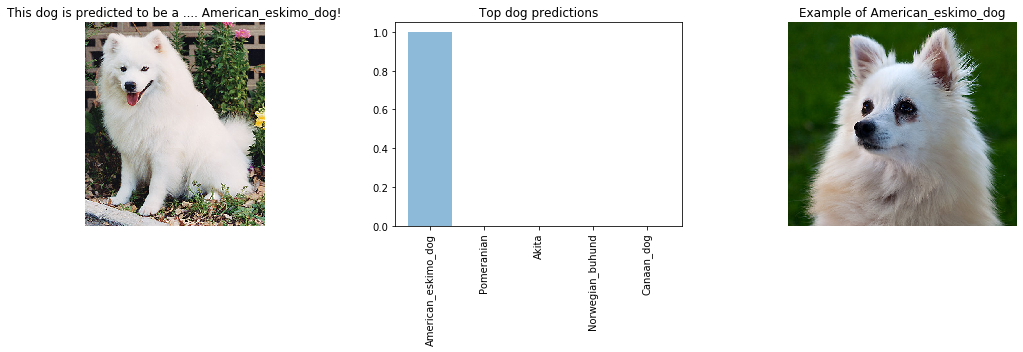

Predicting for dog Finnish_spitz


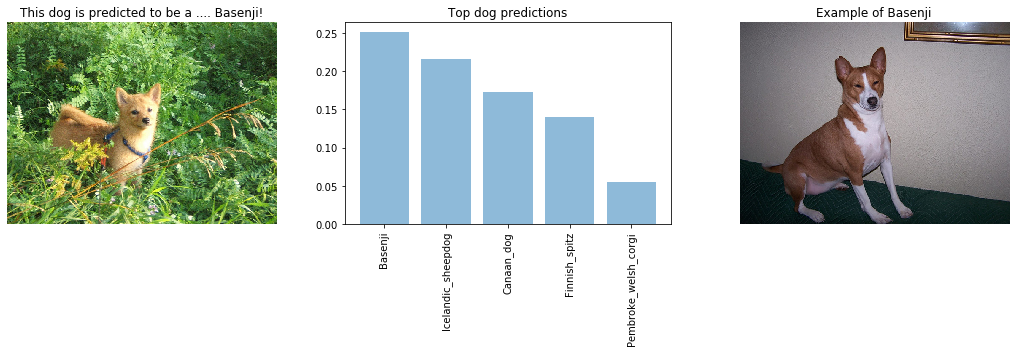

Predicting for dog Alaskan_malamute


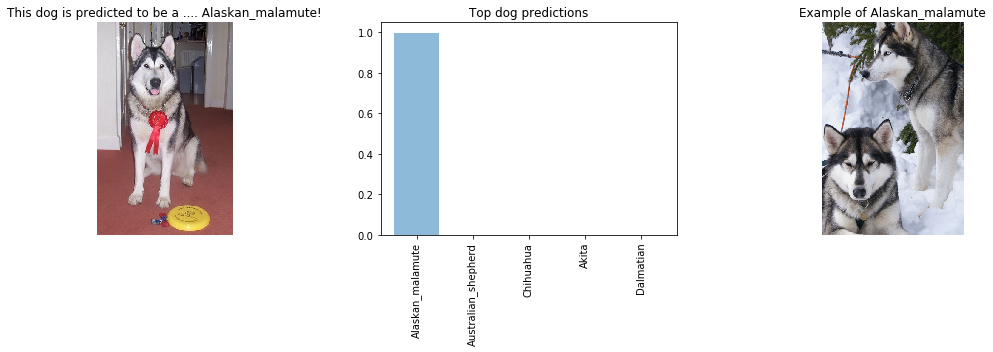

Predicting for dog Icelandic_sheepdog


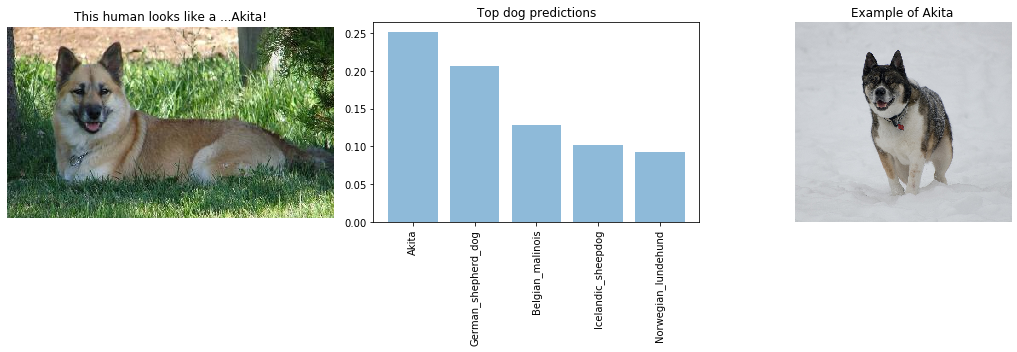

Predicting for dog Entlebucher_mountain_dog


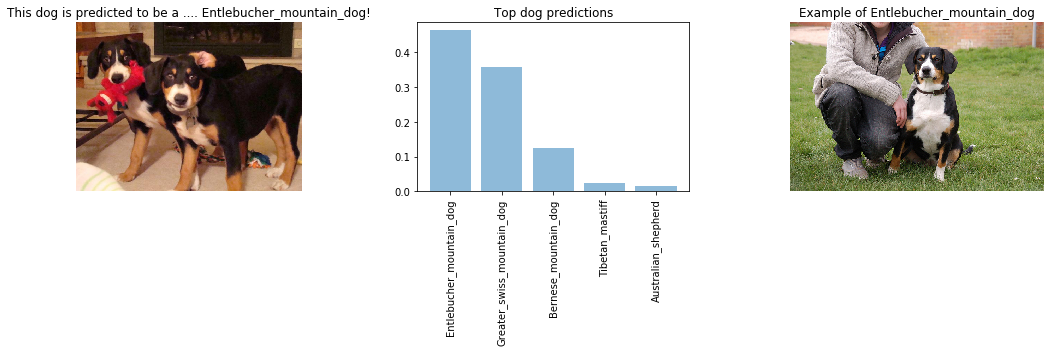

Predicting for dog Border_terrier


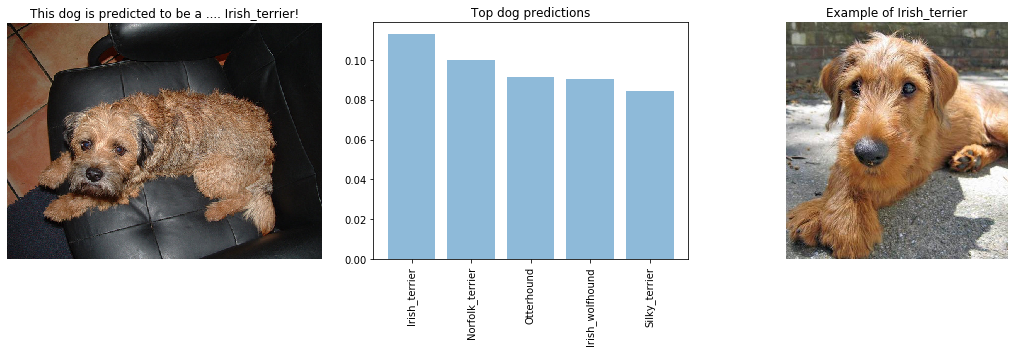

Predicting for dog American_eskimo_dog


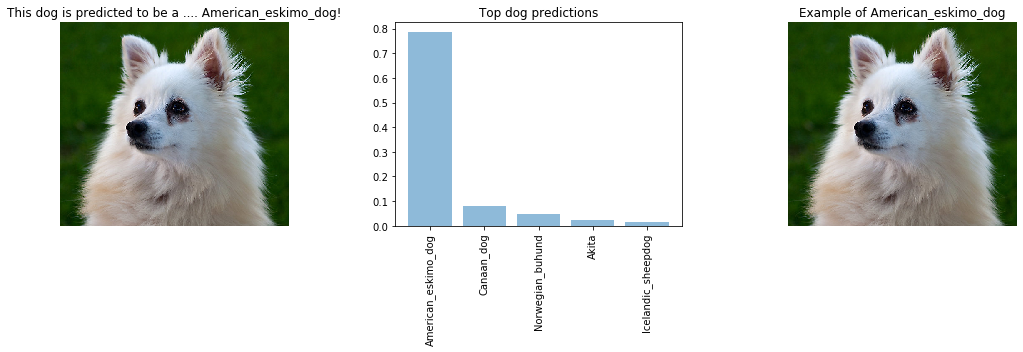

Predicting for dog Greater_swiss_mountain_dog


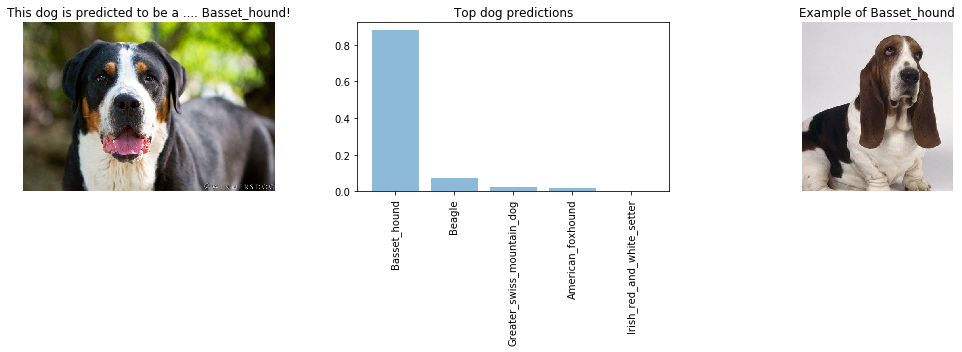

Predicting for dog Flat-coated_retriever


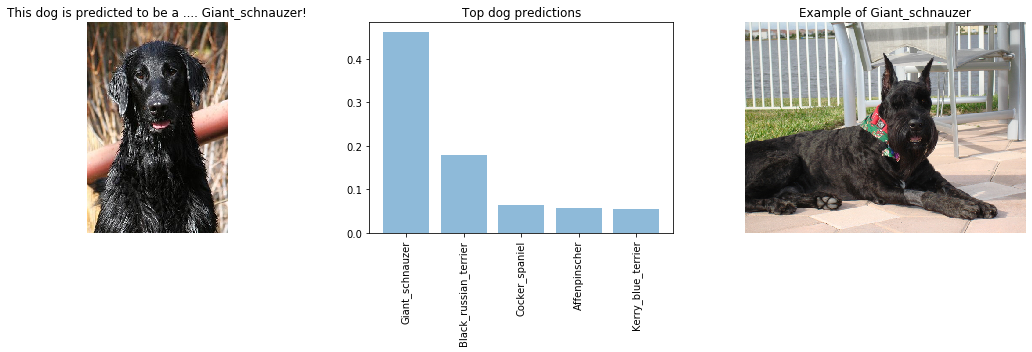

In [19]:
for dog in test_dogs:
    actual_dog = dog.split('\\')[-1][:-10]
    print(f"Predicting for dog {actual_dog}")
    predict_model.create_prediction_fig(dog, model, breeds, save_image=False,
                                        show_image=True, path_dog_files="../data/raw/dogImages/*/*/*")

## Try out on some human images

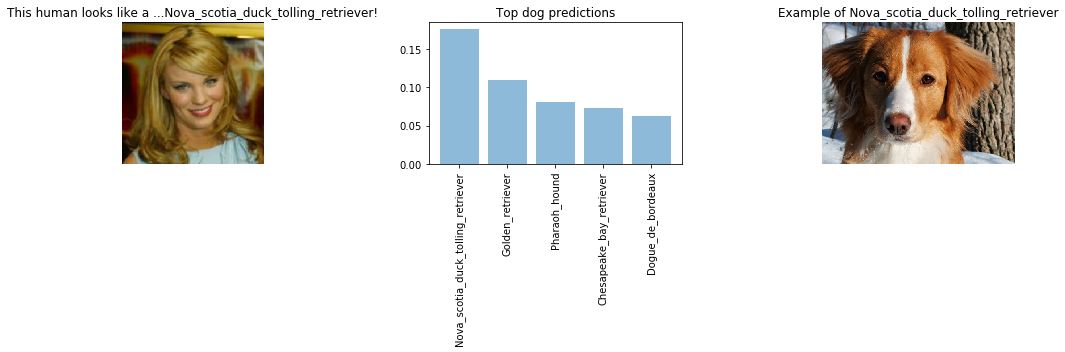

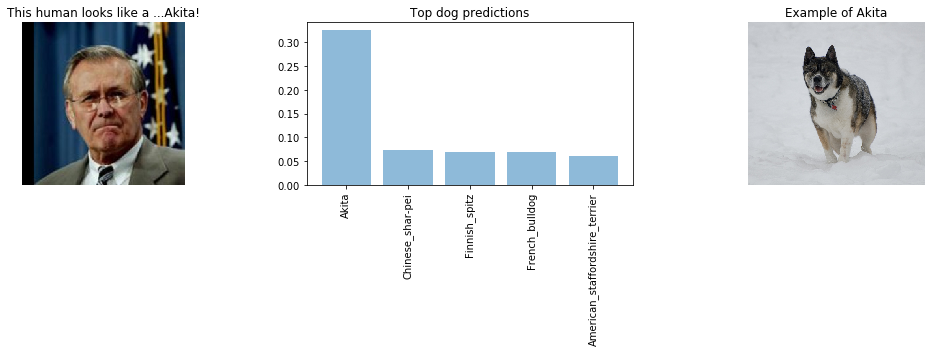

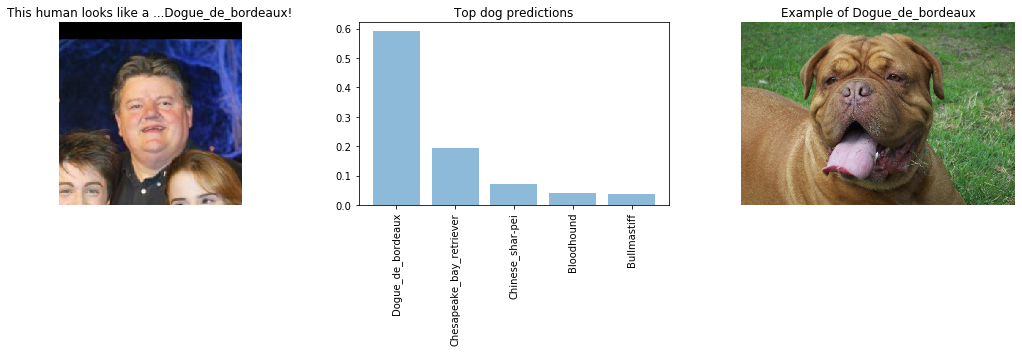

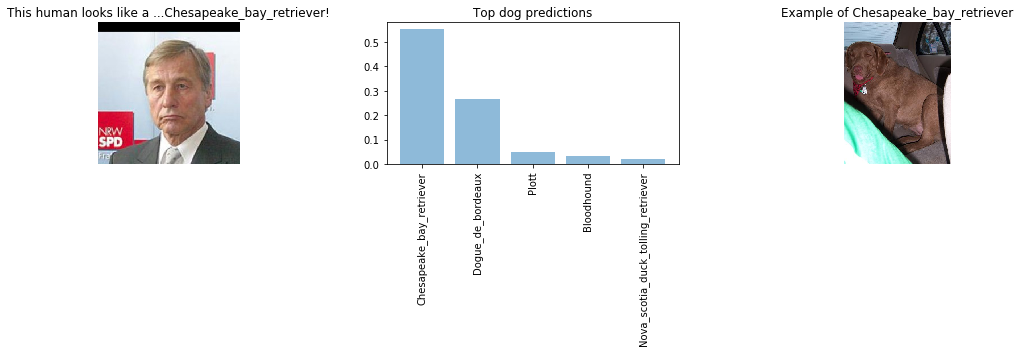

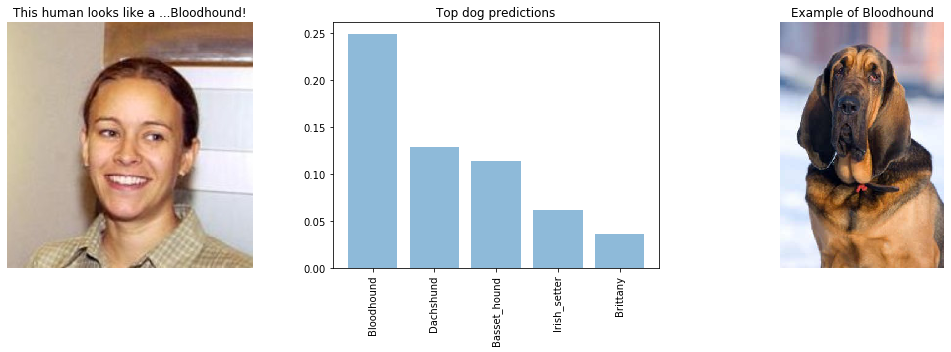

In [20]:
for human in human_files[:5]:
    predict_model.create_prediction_fig(human, model, breeds, save_image=False,
                                        show_image=True, path_dog_files="../data/raw/dogImages/*/*/*")

# Conclusion

Considering that the model is relatively simple, it performs slightly better than I had expected. 
It doesn't get all dogs right (as seen above), but lots of them make sense and when it's wrong the correct dog is often in the top 5 of most likely breeds. 

### Improvements

My algorithm could be improved by 
* training on more images
* training for longer
* finding better hyperparameters for e.g. the ADAM optimizer

Sometimes if I rerun the app it can give quite different outputs, I guess with humans it's just not really sure most of the time (a lot of the probabilities of the top dogs are close together)